In [1]:
import matplotlib.pyplot as plt
import torch.nn as nn
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as T
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import torch.cuda.amp as amp

In [2]:
"""
# Download latest version
dataset_root = kagglehub.dataset_download("mateuszbuda/lgg-mri-segmentation")

print("Path to dataset files:", dataset_root)
"""
dataset_root = r"C:\Users\yuval\.cache\kagglehub\datasets\mateuszbuda\lgg-mri-segmentation\versions\2\kaggle_3m"

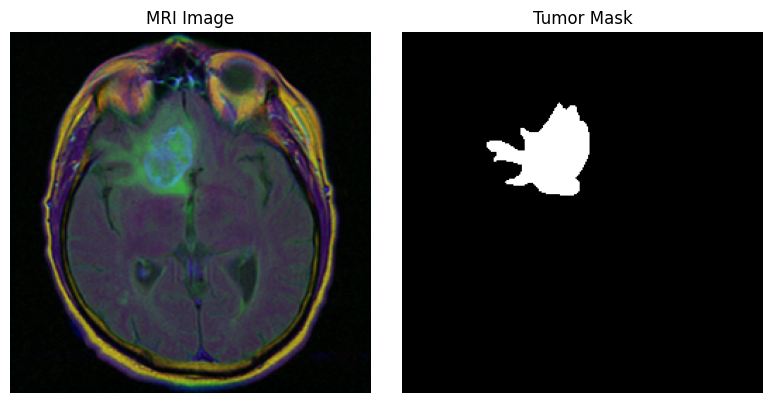

In [3]:
mri_img = Image.open(fr"{dataset_root}\TCGA_CS_4941_19960909\TCGA_CS_4941_19960909_12.tif")
tumor_map = Image.open(fr"{dataset_root}\TCGA_CS_4941_19960909\TCGA_CS_4941_19960909_12_mask.tif")
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].imshow(mri_img, cmap="gray")
axes[0].set_title("MRI Image")
axes[0].axis("off")

axes[1].imshow(tumor_map, cmap="gray")
axes[1].set_title("Tumor Mask")
axes[1].axis("off")

plt.tight_layout()
plt.show()


In [21]:
class ConvBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c), # normalize the data -> how many standard deviations
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, 3, padding=1), # apply another conv (while keeping channel dim) to enrich the output.
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.block(x)

class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = ConvBlock(1, 64)
        self.enc2 = ConvBlock(64, 128)
        self.enc3 = ConvBlock(128, 256)
        self.enc4 = ConvBlock(256, 512)
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        # convolve 256 -> 256 (no pooling)
        x1 = self.enc1(x)
        # down 256 -> 128
        x2 = self.enc2(self.pool(x1))
        # down 128 -> 64
        x3 = self.enc3(self.pool(x2))
        # down 64 -> 32
        x4 = self.enc4(self.pool(x3))
        return x1, x2, x3, x4

class TransformerBottleneck(nn.Module):
    def __init__(self, dim, num_heads=8, num_layers=4, spatial_res=32):
        super().__init__()
        self.pos_embed = nn.Parameter(torch.zeros(1, spatial_res**2, dim)) # learnable pos embeddings
        nn.init.trunc_normal_(self.pos_embed, std=0.02) # init with normal dist

        encoder_layer = nn.TransformerEncoderLayer(d_model=dim, nhead=num_heads, batch_first=True, dropout=0.1, activation='gelu')
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers) # 'num_layers' size transformer

    def forward(self, x):
        B, C, H, W = x.shape
        x = x.flatten(2).transpose(1, 2) # squashes the input into a vector to feed the transformer
        x = x + self.pos_embed
        x = self.transformer(x)
        x = x.transpose(1, 2).view(B, C, H, W) # return to image form
        return x

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        # up 32 -> 64
        self.up1 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv1 = ConvBlock(512, 256)
        # up 64 -> 128
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv2 = ConvBlock(256, 128)
        # up 128 -> 256
        self.up3 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv3 = ConvBlock(128, 64)
        # the predicted map 256 -> 256
        self.out = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, bottleneck_out, x3, x2, x1):
        x = self.up1(bottleneck_out)
        x = torch.cat([x, x3], dim=1)
        x = self.conv1(x)

        x = self.up2(x)
        x = torch.cat([x, x2], dim=1)
        x = self.conv2(x)

        x = self.up3(x)
        x = torch.cat([x, x1], dim=1)
        x = self.conv3(x)

        return self.out(x)

class TumorDetector(nn.Module):
    def __init__(self, img_size=256, u_depth=3):
        super().__init__()
        self.encoder = Encoder()
        self.transformer = TransformerBottleneck(dim=512, spatial_res=img_size // 2**u_depth)
        self.decoder = Decoder()

    def forward(self, x):
        x1, x2, x3, x4 = self.encoder(x)
        bottleneck_out = self.transformer(x4)
        mask_logits = self.decoder(bottleneck_out, x3, x2, x1)
        return mask_logits

In [5]:
class MRIDataset(Dataset):
    def __init__(self, root_dir, limit=20, img_size=256):
        self.samples = []
        self.img_size = img_size

        # take the MRI scans, resize then and convert to tensor
        self.transform_img = T.Compose([
            T.Resize((img_size, img_size)),
            T.ToTensor(),
        ])

        # use Interpolation Mode NEAREST for masks (ground truth images) to avoid creating "blurry" pixels during resizing
        self.transform_mask = T.Compose([
            T.Resize((img_size, img_size), interpolation=T.InterpolationMode.NEAREST),
            T.ToTensor(),
        ])

        i = 0
        # look into all patient folders
        for patient in os.listdir(root_dir):

            if limit and i >= limit: # allows to look into only a specific amount of patients for debugging
                break

            patient_dir = os.path.join(root_dir, patient)

            if not os.path.isdir(patient_dir):
                continue

            # find all images and pair them with their ground truth (mask)
            for fname in os.listdir(patient_dir):
                if fname.endswith(".tif") and not fname.endswith("_mask.tif"):
                    img_path = os.path.join(patient_dir, fname)
                    mask_path = img_path.replace(".tif", "_mask.tif")

                    if os.path.exists(mask_path):
                        self.samples.append((img_path, mask_path))
            i += 1

            # now the samples array is stored as [MRI Image 1, Ground Truth 1, MRI Image 2, Ground Truth 2, ....]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, mask_path = self.samples[idx]

        # load as Grayscale to get rid of redundant information
        image = Image.open(img_path).convert("L")
        mask = Image.open(mask_path).convert("L")

        # apply transforms
        image = self.transform_img(image)
        mask = self.transform_mask(mask)

        # ensure mask is strictly binary (0 or 1)
        # we use a threshold because T.ToTensor() scales pixels to [0, 1]
        mask = (mask > 0.1).float()

        return image, mask

In [6]:
dataset = MRIDataset(dataset_root, limit=None)

# split: 80% train, 20% validation
val_size = int(0.2 * len(dataset))
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True, num_workers=0, pin_memory=True)

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

model = TumorDetector().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3)


cuda


In [20]:
def dice_score(outputs, targets, eps=1e-6):
    probs = torch.sigmoid(outputs)
    preds_bin = (probs > 0.5).float()
    intersection = (preds_bin * targets).sum() # |A cross B|
    union = preds_bin.sum() + targets.sum() # |A u B|
    return (2 * intersection + eps) / (union + eps)

def dice_loss(outputs, targets, eps=1e-6):
    probs = torch.sigmoid(outputs)
    intersection = (probs * targets).sum(dim=(1, 2, 3))
    union = probs.sum(dim=(1, 2, 3)) + targets.sum(dim=(1, 2, 3))
    dice = (2.0 * intersection + eps) / (union + eps)
    return 1.0 - dice.mean()

In [9]:
scaler = amp.GradScaler() # scales the loss for stability (prevents vanishing gradients)

num_epochs = 30

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss, train_dice_score = 0, 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]") # setting dynamic progress bar

    for images, masks in pbar:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()


        with amp.autocast(): # enabling switching between fp16 and fp32 for speed
            outputs = model(images) # feed forward
            loss = (0.8 * dice_loss(outputs, masks)) + (0.2 * criterion(outputs, masks))

        # scaled backprop
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # calc metrics
        _dice_score = dice_score(outputs, masks)
        train_loss += loss.item()
        train_dice_score += _dice_score

        pbar.set_postfix({"loss": f"{loss.item():.4f}", "dice": f"{_dice_score:.4f}"}) # update progress bar

    # Validation
    model.eval()
    val_dice_score, max_p = 0, 0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)

            with amp.autocast(): # enabling switching between fp16 and fp32 for speed
                outputs = model(images) # feed forward

            # calc metrics
            h_dice = dice_score(outputs, masks)
            val_dice_score += h_dice
            max_p = max(max_p, torch.sigmoid(outputs).max().item())

    avg_val_dice = val_dice_score / len(val_loader)

    # reduce lr between epochs based on avg_val_dice
    scheduler.step(avg_val_dice)

    print(f"\nSummary Epoch [{epoch+1}/{num_epochs}] "
          f"Avg Loss: {train_loss/len(train_loader):.4f} | "
          f"Val Dice: {avg_val_dice:.4f} | "
          f"Max Prob: {max_p:.4f} | "
          f"LR: {optimizer.param_groups[0]['lr']:.6f}")
    print("-" * 30)

C:\Users\yuval\AppData\Local\Temp\ipykernel_12660\3772323667.py:2: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()
Epoch 1/30 [Train]:   0%|          | 0/197 [00:00<?, ?it/s]C:\Users\yuval\AppData\Local\Temp\ipykernel_12660\3772323667.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
Epoch 1/30 [Train]: 100%|██████████| 197/197 [07:09<00:00,  2.18s/it, loss=0.8329, dice=0.3503]
C:\Users\yuval\AppData\Local\Temp\ipykernel_12660\3772323667.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():



Summary Epoch [1/30] Avg Loss: 0.8507 | Val Dice: 0.3689 | Max Prob: 1.0000 | LR: 0.000100
------------------------------


Epoch 2/30 [Train]: 100%|██████████| 197/197 [06:56<00:00,  2.11s/it, loss=0.7585, dice=0.3553]



Summary Epoch [2/30] Avg Loss: 0.7907 | Val Dice: 0.4180 | Max Prob: 1.0000 | LR: 0.000100
------------------------------


Epoch 3/30 [Train]: 100%|██████████| 197/197 [07:49<00:00,  2.38s/it, loss=0.7454, dice=0.6170]



Summary Epoch [3/30] Avg Loss: 0.7509 | Val Dice: 0.5364 | Max Prob: 0.9995 | LR: 0.000100
------------------------------


Epoch 4/30 [Train]: 100%|██████████| 197/197 [06:13<00:00,  1.90s/it, loss=0.7399, dice=0.4083]



Summary Epoch [4/30] Avg Loss: 0.7150 | Val Dice: 0.2594 | Max Prob: 1.0000 | LR: 0.000100
------------------------------


Epoch 5/30 [Train]: 100%|██████████| 197/197 [06:13<00:00,  1.89s/it, loss=0.6683, dice=0.4614]



Summary Epoch [5/30] Avg Loss: 0.6872 | Val Dice: 0.5358 | Max Prob: 1.0000 | LR: 0.000100
------------------------------


Epoch 6/30 [Train]: 100%|██████████| 197/197 [06:13<00:00,  1.89s/it, loss=0.6435, dice=0.5021]



Summary Epoch [6/30] Avg Loss: 0.6707 | Val Dice: 0.5780 | Max Prob: 1.0000 | LR: 0.000100
------------------------------


Epoch 7/30 [Train]: 100%|██████████| 197/197 [06:13<00:00,  1.90s/it, loss=0.6178, dice=0.6122]



Summary Epoch [7/30] Avg Loss: 0.6556 | Val Dice: 0.5140 | Max Prob: 1.0000 | LR: 0.000100
------------------------------


Epoch 8/30 [Train]: 100%|██████████| 197/197 [06:14<00:00,  1.90s/it, loss=0.5632, dice=0.7415]



Summary Epoch [8/30] Avg Loss: 0.6438 | Val Dice: 0.6507 | Max Prob: 1.0000 | LR: 0.000100
------------------------------


Epoch 9/30 [Train]: 100%|██████████| 197/197 [06:14<00:00,  1.90s/it, loss=0.6192, dice=0.5528]



Summary Epoch [9/30] Avg Loss: 0.6306 | Val Dice: 0.6361 | Max Prob: 1.0000 | LR: 0.000100
------------------------------


Epoch 10/30 [Train]: 100%|██████████| 197/197 [06:13<00:00,  1.90s/it, loss=0.6147, dice=0.6681]



Summary Epoch [10/30] Avg Loss: 0.6218 | Val Dice: 0.5709 | Max Prob: 1.0000 | LR: 0.000100
------------------------------


Epoch 11/30 [Train]: 100%|██████████| 197/197 [06:13<00:00,  1.90s/it, loss=0.4088, dice=0.8468]



Summary Epoch [11/30] Avg Loss: 0.6167 | Val Dice: 0.6252 | Max Prob: 1.0000 | LR: 0.000100
------------------------------


Epoch 12/30 [Train]: 100%|██████████| 197/197 [06:13<00:00,  1.89s/it, loss=0.4112, dice=0.7069]



Summary Epoch [12/30] Avg Loss: 0.6100 | Val Dice: 0.5179 | Max Prob: 1.0000 | LR: 0.000010
------------------------------


Epoch 13/30 [Train]: 100%|██████████| 197/197 [06:13<00:00,  1.90s/it, loss=0.6313, dice=0.8649]



Summary Epoch [13/30] Avg Loss: 0.5957 | Val Dice: 0.7366 | Max Prob: 1.0000 | LR: 0.000010
------------------------------


Epoch 14/30 [Train]: 100%|██████████| 197/197 [06:13<00:00,  1.90s/it, loss=0.4707, dice=0.8541]



Summary Epoch [14/30] Avg Loss: 0.5902 | Val Dice: 0.7710 | Max Prob: 1.0000 | LR: 0.000010
------------------------------


Epoch 15/30 [Train]: 100%|██████████| 197/197 [06:13<00:00,  1.89s/it, loss=0.5327, dice=0.8926]



Summary Epoch [15/30] Avg Loss: 0.5880 | Val Dice: 0.7632 | Max Prob: 1.0000 | LR: 0.000010
------------------------------


Epoch 16/30 [Train]: 100%|██████████| 197/197 [06:13<00:00,  1.90s/it, loss=0.4684, dice=0.8586]



Summary Epoch [16/30] Avg Loss: 0.5864 | Val Dice: 0.7754 | Max Prob: 1.0000 | LR: 0.000010
------------------------------


Epoch 17/30 [Train]: 100%|██████████| 197/197 [06:13<00:00,  1.90s/it, loss=0.7124, dice=0.6215]



Summary Epoch [17/30] Avg Loss: 0.5856 | Val Dice: 0.7569 | Max Prob: 1.0000 | LR: 0.000010
------------------------------


Epoch 18/30 [Train]: 100%|██████████| 197/197 [06:13<00:00,  1.90s/it, loss=0.6325, dice=0.7143]



Summary Epoch [18/30] Avg Loss: 0.5843 | Val Dice: 0.7917 | Max Prob: 1.0000 | LR: 0.000010
------------------------------


Epoch 19/30 [Train]: 100%|██████████| 197/197 [06:13<00:00,  1.89s/it, loss=0.5458, dice=0.8624]



Summary Epoch [19/30] Avg Loss: 0.5829 | Val Dice: 0.7780 | Max Prob: 1.0000 | LR: 0.000010
------------------------------


Epoch 20/30 [Train]: 100%|██████████| 197/197 [06:13<00:00,  1.89s/it, loss=0.5515, dice=0.7628]



Summary Epoch [20/30] Avg Loss: 0.5817 | Val Dice: 0.7937 | Max Prob: 1.0000 | LR: 0.000010
------------------------------


Epoch 21/30 [Train]: 100%|██████████| 197/197 [06:13<00:00,  1.90s/it, loss=0.7804, dice=0.2111]



Summary Epoch [21/30] Avg Loss: 0.5811 | Val Dice: 0.7931 | Max Prob: 1.0000 | LR: 0.000010
------------------------------


Epoch 22/30 [Train]: 100%|██████████| 197/197 [06:13<00:00,  1.90s/it, loss=0.7301, dice=0.3029]



Summary Epoch [22/30] Avg Loss: 0.5805 | Val Dice: 0.7441 | Max Prob: 1.0000 | LR: 0.000010
------------------------------


Epoch 23/30 [Train]: 100%|██████████| 197/197 [06:13<00:00,  1.89s/it, loss=0.4769, dice=0.7935]



Summary Epoch [23/30] Avg Loss: 0.5782 | Val Dice: 0.8097 | Max Prob: 1.0000 | LR: 0.000010
------------------------------


Epoch 24/30 [Train]: 100%|██████████| 197/197 [06:13<00:00,  1.90s/it, loss=0.6203, dice=0.8125]



Summary Epoch [24/30] Avg Loss: 0.5777 | Val Dice: 0.7896 | Max Prob: 1.0000 | LR: 0.000010
------------------------------


Epoch 25/30 [Train]: 100%|██████████| 197/197 [06:13<00:00,  1.90s/it, loss=0.5558, dice=0.8805]



Summary Epoch [25/30] Avg Loss: 0.5766 | Val Dice: 0.8176 | Max Prob: 1.0000 | LR: 0.000010
------------------------------


Epoch 26/30 [Train]: 100%|██████████| 197/197 [06:13<00:00,  1.90s/it, loss=0.7176, dice=0.5792]



Summary Epoch [26/30] Avg Loss: 0.5763 | Val Dice: 0.7944 | Max Prob: 1.0000 | LR: 0.000010
------------------------------


Epoch 27/30 [Train]: 100%|██████████| 197/197 [06:13<00:00,  1.90s/it, loss=0.4767, dice=0.8274]



Summary Epoch [27/30] Avg Loss: 0.5746 | Val Dice: 0.8073 | Max Prob: 1.0000 | LR: 0.000010
------------------------------


Epoch 28/30 [Train]: 100%|██████████| 197/197 [06:13<00:00,  1.90s/it, loss=0.4714, dice=0.8865]



Summary Epoch [28/30] Avg Loss: 0.5743 | Val Dice: 0.8137 | Max Prob: 1.0000 | LR: 0.000010
------------------------------


Epoch 29/30 [Train]: 100%|██████████| 197/197 [06:13<00:00,  1.90s/it, loss=0.5301, dice=0.8986]



Summary Epoch [29/30] Avg Loss: 0.5743 | Val Dice: 0.8150 | Max Prob: 1.0000 | LR: 0.000001
------------------------------


Epoch 30/30 [Train]: 100%|██████████| 197/197 [06:13<00:00,  1.90s/it, loss=0.4698, dice=0.8465]



Summary Epoch [30/30] Avg Loss: 0.5717 | Val Dice: 0.8118 | Max Prob: 1.0000 | LR: 0.000001
------------------------------


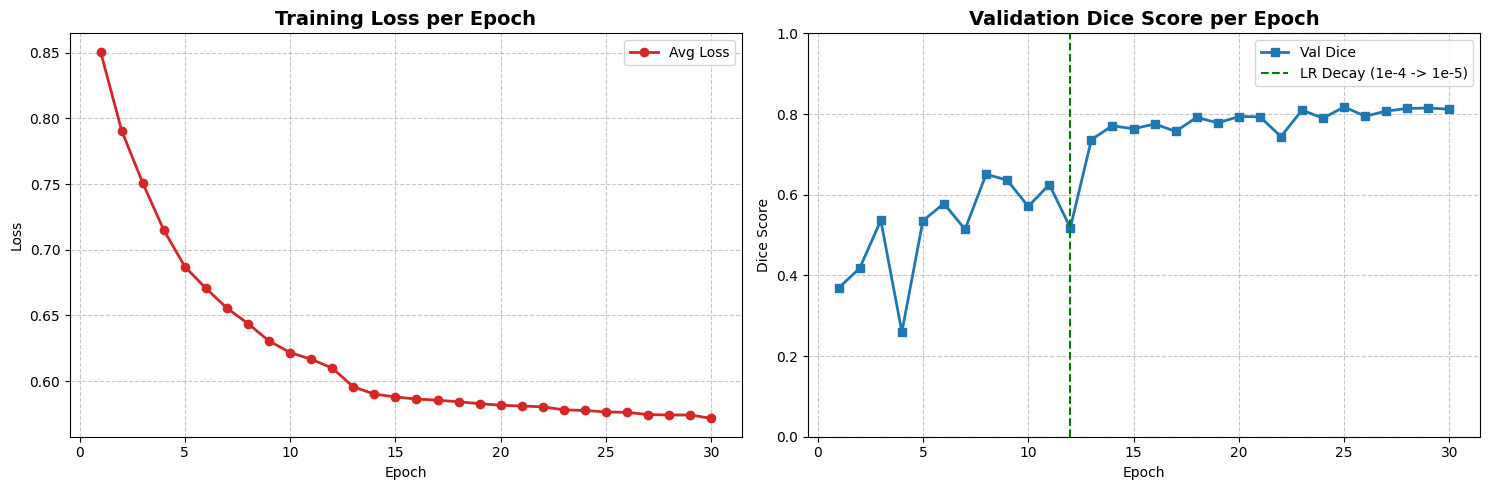

In [2]:
# Data extracted from your training logs
# we didnt want to run the entire 3+ hours training loop again so we have copied the logs to the lists below
epochs = list(range(1, 31))
avg_loss = [
    0.8507, 0.7907, 0.7509, 0.7150, 0.6872, 0.6707, 0.6556, 0.6438, 0.6306, 0.6218,
    0.6167, 0.6100, 0.5957, 0.5902, 0.5880, 0.5864, 0.5856, 0.5843, 0.5829, 0.5817,
    0.5811, 0.5805, 0.5782, 0.5777, 0.5766, 0.5763, 0.5746, 0.5743, 0.5743, 0.5717
]
val_dice = [
    0.3689, 0.4180, 0.5364, 0.2594, 0.5358, 0.5780, 0.5140, 0.6507, 0.6361, 0.5709,
    0.6252, 0.5179, 0.7366, 0.7710, 0.7632, 0.7754, 0.7569, 0.7917, 0.7780, 0.7937,
    0.7931, 0.7441, 0.8097, 0.7896, 0.8176, 0.7944, 0.8073, 0.8137, 0.8150, 0.8118
]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Training Loss
ax1.plot(epochs, avg_loss, color='tab:red', marker='o', linestyle='-', linewidth=2, label='Avg Loss')
ax1.set_title('Training Loss per Epoch', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.legend()

# Plot 2: Validation Dice
ax2.plot(epochs, val_dice, color='tab:blue', marker='s', linestyle='-', linewidth=2, label='Val Dice')
ax2.axvline(x=12, color='green', linestyle='--', label='LR Decay (1e-4 -> 1e-5)')
ax2.set_title('Validation Dice Score per Epoch', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Dice Score')
ax2.set_ylim(0, 1.0)
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.legend()

plt.tight_layout()
plt.show()

In [18]:
# Save model
torch.save(model.state_dict(), "models/brain_tumor_model_v3/brain_tumor_model_v3.pth")
print("Model saved as brain_tumor_model_v3.pth")

Model saved as brain_tumor_model_v3.pth
